# Programming Metodologies for Data Analysis

## Authors
- Lorenzo Dell'Oro
- Giovanni Toto
- Gian Luca Vriz

## 1. Introduction

<font color='red'>KEY IDEA AND OBJECTIVE OF THE PROJECT</font>

<font color='blue'>LIBRARIES</font>

In [3]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import os
import pandas as pd
import re
import string
import torch
import xml.etree.ElementTree

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Guardian dataset

<font color='red'>INTRODUCTION TO DATA</font>

The Guardian is one of the most important newspapers in the United Kingdom and in the english-speaking world. Its widely recognized reputation makes it one of the most reliable sources about global issues, such as the climate change.
Since the latter is one of the most discussed topic in the last years, our aim is to study if and how the keywords of the related mainstream public debate and information changed in the last decade, i.e. between 2013 and 2022.

### 2.i. Download using API

In order to obtain the best dataset according to the needs of our analysis, we downloaded the articles from [The Open Platform]((https://open-platform.theguardian.com/)), the Guardian's official API.

The downloaded articles are selected by the following query:
- type = 'article', to exclude other types of contents, such as video and audio files;
- section = 'environment', to select only articles published in that section of  the newspaper;
- q = '"climate change"', to get only the articles that contain that two words in that order;
- the date of the downloaded articles spans from the beginning of 2013 to the end of 2022;
- lang = 'en' assures that all the selected articles are written in the same language (english), a basic request of text mining
- order-by, page-size, show-fields and api-key are technical arguments of the query

We need an API key in order to download the articles: in the following block, you should replace `'test'` with your API key; it can be easily obtained [here](https://open-platform.theguardian.com/access/).

In [ ]:
"""
api_key = "test"
query = {'type': 'article',
         'q': '"climate change"',
         'section': 'environment',
         'from-date': "2013-01-01",
         'to-date': "2022-12-31",
         'lang': 'en',
         'order-by': 'oldest',
         'page-size': 200,
         'show-fields': 'all',
         'api-key': api_key}

from src.file_io import download_guardian
corpus = download_guardian(query, 'data/raw/guardian_environment.csv')
"""
corpus = pd.read_csv('data/raw/guardian_environment.csv')

### 2.ii Selection of the variable of interest

`corpus` is a `pandas` dataset containing several pieces of information for each document, most of which are not relevant to our analysis; hence, we keep only the following fields:
- document-related:
    - `id`: identifier
    - `year`: year of publication on the website (`webPublicationDate`)
    - `where`: original place on which the article was published (`fields_publication`)
    - `author`: author (`fields_byline`)
- text-related:
    - `headline`: title (`fields_headline`)
    - `standfirst`: summary (`fields_standfirst`)
    - `body`: text with tags (`fields_body`)
    - `bodyText`: text without tags (`fields_bodyText`)
- count-related:
    - `wordcount`: number of words in the body (`fields_wordcount`)
    - `charcount`: number of characters in the body without tags (`fields_charcount`)
    
We reporte in parentheses the original name of the field or, in the case of `year`, the name of the field from which `year` was obtained.

In [ ]:
col_of_interest = ['id', 'webPublicationDate', 'fields_publication', 'fields_byline',
                   'fields_headline', 'fields_standfirst', 'fields_body', 'fields_bodyText',
                   'fields_wordcount', 'fields_charCount']
# select columns of interest
corpus = corpus.loc[:, col_of_interest]
# convert 'webPublicationDate' field to year
corpus['webPublicationDate'] = pd.to_datetime(corpus['webPublicationDate']).dt.year
# rename columns
new_colnames = {'webPublicationDate': 'year', 'fields_publication': 'where', 'fields_byline': 'author',
                'fields_headline': 'headline', 'fields_standfirst': 'standfirst', 'fields_body': 'body', 'fields_bodyText':'bodyText',
                'fields_wordcount': 'wordcount', 'fields_charCount': 'charcount'}
corpus.rename(columns=new_colnames, inplace=True)

Then, we remove the articles which do not have a body, i.e. the value of `bodyText` is `nan`.

In [ ]:
corpus = corpus[corpus['bodyText'].isna() == False]

Finally, if an article does not have the headline and/or standfirst, we replace the `nan`s with empty strings.

In [ ]:
corpus['headline'][corpus['headline'].isna() == True] = ''
corpus['standfirst'][corpus['standfirst'].isna() == True] = ''

### 2.ii. Pre-processing of the texts

<font color='blue'>PRE-PROCESSING OF TEXTS</font>

In this section we consider the texts of the article downloaded in the previous section and we process them in order to make them compatible with *ETM* and *DETM*. In particular, we want to obtain two list of strings:
- `timestamps` containing the timestamps of the articles, i.e. the years in which they were published;
- `docs` containing the processed texts of the articles, i.e. the headline, standfirst and body.


First, we obtain `timestamps` variable from year field:

In [ ]:
timestamps = [str(y) for y in corpus['year'].tolist()]

Then, we process the texts in order to obtain an input compatible with text analysis approaches:

In [ ]:
# regex for urls; source: https://stackoverflow.com/a/50790119
url_regex = r"\b((?:https?://)?(?:(?:www\.)?(?:[\da-z\.-]+)\.(?:[a-z]{2,6})|(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)|(?:(?:[0-9a-fA-F]{1,4}:){7,7}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,7}:|(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}|(?:[0-9a-fA-F]{1,4}:){1,4}(?::[0-9a-fA-F]{1,4}){1,3}|(?:[0-9a-fA-F]{1,4}:){1,3}(?::[0-9a-fA-F]{1,4}){1,4}|(?:[0-9a-fA-F]{1,4}:){1,2}(?::[0-9a-fA-F]{1,4}){1,5}|[0-9a-fA-F]{1,4}:(?:(?::[0-9a-fA-F]{1,4}){1,6})|:(?:(?::[0-9a-fA-F]{1,4}){1,7}|:)|fe80:(?::[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|::(?:ffff(?::0{1,4}){0,1}:){0,1}(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])|(?:[0-9a-fA-F]{1,4}:){1,4}:(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])))(?::[0-9]{1,4}|[1-5][0-9]{4}|6[0-4][0-9]{3}|65[0-4][0-9]{2}|655[0-2][0-9]|6553[0-5])?(?:/[\w\.-]*)*/?)\b"
tag_regex = re.compile('<.*?>')

docs = corpus['headline'] + " " + corpus['standfirst'] + " " + corpus['bodyText']
docs = docs.tolist()
docs = [re.sub(url_regex, '', docs[doc]).lower() for doc in range(len(docs))]
docs = [re.sub(tag_regex, '', docs[doc]) for doc in range(len(docs))]
docs = [[w.translate(str.maketrans('', '', string.punctuation + "0123456789")) for w in docs[doc].split()] for doc in range(len(docs))]
docs = [[w for w in docs[doc] if len(w)>1] for doc in range(len(docs))]
docs = [" ".join(docs[doc]) for doc in range(len(docs))]

Finally, we use `preprocessing` function contained in `src/preprocessing.py` module, which creates files compatible with *ETM* and *DETM*. Before launching the function, we need to import stopwords:

In [ ]:
# Read stopwords
with open("./data/stops.txt", "r") as f:
    stopwords = f.read().split('\n')
# Pre-processing
data_path = 'data/guardian_environment'
from src.preprocessing import preprocessing
preprocessing(data_path=data_path, docs=docs, timestamps=timestamps, stopwords=stopwords,
              min_df=50, max_df=0.7, data_split=[0.7, 0.2, 0.1], seed=28)

The last function also divides the corpus into train, test and validation set: we are going to consider the training set only for the exploratory analyses in the next section.

## 3. Exploratory analysis

<font color='blue'>
EXPLORATORY ANALYSIS OF THE <b>TRAIN</b> CORPUS:

- tabella con info corpus (num documenti, num timestamps, documenti per timestamp, ...)
- distribuzione lunghezza documenti (numero parole)
- parole più frequenti (word cloud)
</font>

Before moving on, we remove all variables that are no longer used:

In [ ]:
del col_of_interest, docs, new_colnames, url_regex

In [39]:
#import asyncio
#import itertools
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
#import time

from collections import Counter
from ipywidgets import widgets
from PIL import Image
#from scipy import stats as st
from wordcloud import WordCloud

from src.exploratory_analysis import most_used_words, top_authors

As said before, here we consider train set only: we do not need test and validation set from now on, so we replace the whole corpus, stored in `corpus` variable, with the train set. We also store the vocabulary of the train set in `vocab` variable.

In [ ]:
with open('data/guardian_environment/info.json', 'r') as f:
    info = json.load(f)
    vocab = info['vocab_tr']
    corpus = corpus.iloc[info['indices_tr'], :]
    docs_bow = [[vocab[v] for v in doc] for doc in info['docs_tr']]
    del info

docs_by_year = {}
year_list = sorted(list(set(timestamps)))
for year in year_list:
    docs_by_year[year] = [docs_bow[d] for d in range(len(docs_bow)) if timestamps[d] == year]

In the following block, we perform exploratory data analysis (EDA) on the dataset imported by the previous query. The EDA is an approach of analyzing data sets to summarize their main characteristics (using statistical graphics and other data visualization methods). Firstly we implement a bar plot to show the repartition of articles by publication date.

In [ ]:
fig = px.bar(corpus.groupby(['year'])['year'].count().reset_index(name='number of articles'), x='year', y='number of articles',
             title="Bar plot by pubblication date", labels=dict(year='year'))
fig.update_traces(marker_color='steelblue')
fig.update_traces(marker_line_width=1, marker_line_color='black')
fig.show()

The first two years for the number of published articles were 2015 and 2021. This trend could be the consequence of two main events in the UK's coal industry. In 2015, the government announced that all remaining coal-fired power stations would be closed by 2025. While in 2021, it brought forward its coal phase-out target to 2024. The least value of publications was in 2020, which coincides with the start of the Covid-19 pandemic across Europe.

The following graph presents the distribution of the articles by the number of words. We have to note that the distribution presents a long-right tail. So, to have a better representation we may restrict the attention only to the articles with a number of words less than 3000.

In [ ]:
fig, ax = plt.subplots(figsize=(12,6)) 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
sns.set(style='darkgrid')
sns.histplot(data=corpus, x="wordcount", kde=True, edgecolor='black', color='steelblue')
ax.lines[0].set_color('crimson')
plt.xlabel('Number of words', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Histogram on wordcount', fontsize=16)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
print('Documents with more than 3000 words are', len(corpus[corpus['wordcount'] >= 3000]))
sns.set(style='darkgrid')
sns.histplot(data=corpus, x='wordcount', kde=True, edgecolor='black', color='steelblue')
ax.lines[0].set_color('crimson')
plt.xlabel('Number of words', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Histogram on wordcount', fontsize=16)
plt.xlim(0,3000)
m = plt.axvline(np.mean(corpus['wordcount']), linewidth=2.5, color='black', label='mean')
q_1 = plt.axvline(np.percentile(corpus['wordcount'], 25), linestyle='--', color='black', label='quartiles')
q_2 = plt.axvline(np.percentile(corpus['wordcount'], 50), linestyle='--', color='black')
q_3 = plt.axvline(np.percentile(corpus['wordcount'], 75), linestyle='--', color='black')
plt.legend(handles=[m, q_1])
plt.show()

Moreover, the distribution has a mean equal to 846 words, while the median is equal to 751 and the mode is 638. If a frequency distribution graph has a symmetrical frequency curve, then the mean, median and mode will be equal. However, in our case, we have a positively skewed frequency distribution, and therefore the mean is always greater than the median and the median is always greater than the mode.

All the articles can be published through three main routes. Directly in "The Guardian" paper magazine, in "The Observer" sub-journal and in the online website "theguardian.com". The division of all the articles is reported in the pie chart below.

In [ ]:
fig = px.pie(corpus.groupby(['where'])['where'].count().reset_index(name='count'), values='count', names='where',
             title='Pie chart on sub-journals', hole=0.35)
fig.update_traces(textposition='outside', textinfo='percent+label',marker=dict(line=dict(color='#000000', width=4)),
                                  pull=[0.00, 0.00, 0.00], opacity=0.9)
fig.show()

With the same reasoning, all articles can be grouped by author. In the following, we plot the first 15 authors by the number of publications.

In [ ]:
top_authors(corpus, 15)

With the last exploratory analysis, we try to answer the following question. What are the most used words in the timeframe from 2013 to 2023 in this field?

In [ ]:
most_used_words(docs_bow, 15)

It is interesting to note that the first five words are *energy*, *emission*, *global*, *government* and *carbon*. Thus, this could mean that the main topic in climate change from 2013 to 2023 was based on the interconnection between government policies and industry in the United Kingdom.

To have a complete representation of word frequences a *Word Cloud Generator* is also reported to visualize data.

In [ ]:
wc = WordCloud(background_color='white',
               mask=np.array(Image.open('images/guardian.png')),
               contour_width=30,
               colormap='Blues',
               contour_color='dodgerblue').generate_from_frequencies(tot_dword)

plt.figure(figsize = (12,12))
plt.imshow(wc, interpolation='bilinear', aspect='auto')
plt.axis('off')
plt.show()

Finally, we perform a "Word Cloud Generator" also considering every single year.

In [ ]:
@widgets.interact(year=year_list)
def get_wordcloud(year):
    docs_bowf_year = [item for sublist in docs_by_year[str(year)] for item in sublist]
    docs_bowf_count_year = Counter(docs_bowf_year)

    tot_dwords_year = {}
    tot_dword_year = dict(sorted(docs_bowf_count_year.items(), key = lambda item: item[1]))

    wordcloud = WordCloud(background_color='white', contour_width=30, colormap='Blues',
                          contour_color='dodgerblue').generate_from_frequencies(tot_dword_year)

    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

## 4. Word embeddings

<font color='red'>BRIEF DESCRIPTION OF THE DIFFERENT APPROACHES</font><br>
<font color='blue'>EMBEDDING FITTING</font><br>

Static word embeddings:
- *GloVe* <br> (Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. Glove: Global vectors for word representation. In EMNLP.)
- *Word2vec* (*CBOW* & *Skip Gram*) <br> (Mikolov, Tomas & Chen, Kai & Corrado, G.s & Dean, Jeffrey. (2013). Efficient Estimation of Word Representations in Vector Space. Proceedings of Workshop at ICLR. 2013.) <br> (Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, and Jeffrey Dean. 2013. Distributed representations of words and phrases and their compositionality. In Proceedings of the 26th International Conference on Neural Information Processing Systems - Volume 2 (NIPS'13). Curran Associates Inc., Red Hook, NY, USA, 3111–3119.)
- *Sent2Vec* <br> (Matteo Pagliardini, Prakhar Gupta, and Martin Jaggi. 2018. Unsupervised learning of sentence embeddings using compositional n-gram features. In NAACL-HLT.)
- *fastText* <br>

Static word embeddings obtained from dynamic ones:
- Prakhar Gupta and Martin Jaggi. 2021. Obtaining Better Static Word Embeddings Using Contextual Embedding Models. In Proceedings of the 59th Annual Meeting of the Association for Computational Linguistics and the 11th International Joint Conference on Natural Language Processing (Volume 1: Long Papers), pages 5241–5253, Online. Association for Computational Linguistics. ([GitHub](https://github.com/epfml/X2Static))

We want the use the same embedding space for both *ETM* and *DETM*, so we first fit the word embeddings and then we provide them as input to the topic models. We import here the required functions:

In [ ]:
from gensim.models import FastText, KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from src.file_io import save_embeddings

embedding_folder, embedding_file = 'embeddings/', 'guardian_environment'
embedding_path = embedding_folder + embedding_file
pretrained_folder = embedding_folder + 'pretrained/'

### 4.i. Random embeddings

We create an empty file, i.e. we fit embeddings for 0 words, in order to estimate a *ETM* in which all the wrod embeddings are sampled randomly.

In [57]:
emb_file = embedding_path + '_random.txt'
with open(emb_file, 'w') as empty_file: 
    pass

### 4.ii. Word2vec on train corpus

We fit CBOW and skip gram on train corpus:

In [ ]:
# sg=0: CBOW
emb_file = embedding_path + '_cbow.txt'
if not os.path.isfile(emb_file):
    cbow = Word2Vec(sentences=docs_bow, min_count=1, sg=0, size=300, iter=10, workers=5, negative=5, window=10)
    save_embeddings(emb_model=cbow, emb_file=emb_file, vocab=vocab)
    del cbow
# sg=1: skipgram
emb_file = embedding_path + '_skipgram.txt'
if not os.path.isfile(emb_file):
    skipgram = Word2Vec(sentences=docs_bow, min_count=1, sg=1, size=300, iter=10, workers=5, negative=5, window=10)
    save_embeddings(emb_model=skipgram, emb_file=emb_file, vocab=vocab)
    del skipgram

### 4.iii. FastText on train corpus

In [ ]:
emb_file = embedding_path + '_fasttext.txt'
if not os.path.isfile(emb_file):
    fasttext = FastText(sentences=docs_bow, min_count=1, size=300, iter=10, negative=5, window=10)
    save_embeddings(emb_model=fasttext, emb_file=emb_file, vocab=vocab)
    del fasttext

### 4.iv. Google’s Word2vec

First, we download the pre-trained word embedding from [here](https://code.google.com/archive/p/word2vec/).

In [ ]:
emb_file = embedding_path + '_google_word2vec.txt'
if not os.path.isfile(emb_file):
    google_word2vec = KeyedVectors.load_word2vec_format(pretrained_folder+'GoogleNews-vectors-negative300.bin', binary=True)
    save_embeddings(emb_model=google_word2vec, emb_file=emb_file, vocab=vocab)
    del google_word2vec

### 4.v. Stanford’s GloVe

First, we download the pre-trained word embedding from [here](https://nlp.stanford.edu/projects/glove/).

In [ ]:
emb_file = embedding_path + '_glove.txt'
# create word2vec file if it does not exist
glove_input_file = pretrained_folder + 'glove.6B.300d.txt'
word2vec_output_file = pretrained_folder + 'glove.6B.300d.bin'
if not os.path.isfile(word2vec_output_file):
    glove2word2vec(glove_input_file, word2vec_output_file)
# load and save embeddings
if not os.path.isfile(emb_file):
    glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
    save_embeddings(emb_model=glove, emb_file=emb_file, vocab=vocab)
    del glove
del emb_file, glove_input_file, word2vec_output_file

## 5 Topic models

<font color='red'>INTRODUCTION TO MODEL ESTIMATION</font>

In [61]:
from src.main_ETM import main_ETM

data_path = 'data/guardian_environment'

embedding_folder, embedding_file = 'embeddings/', 'guardian_environment'
embedding_path = embedding_folder + embedding_file
pretrained_folder = embedding_folder + 'pretrained/'

In [62]:
save_path = 'results'

epochs = 100
batch_size = 1000

topics_list = [10, 20, 30, 40, 50]
# dict('emb_name': emb_size)
embedding_list = {'cbow': 300, 'skipgram': 300, 'fasttext': 300, 'google_word2vec': 300, 'glove': 300, 'random': 300}

### 5.i. Embedded Topic Model (ETM)

<font color='red'>BRIEF DESCRIPTION OF THE MODEL</font><br>
<font color='blue'>MODEL ESTIMATION</font><br>

Wall time: 2h 16min 38s

In [ ]:
%%time
for emb_name, emb_size in embedding_list.items():
    for topics in topics_list:
        dataset = data_path.split("/")[-1] + '_' + emb_name + '_' + str(topics)
        emb_file = embedding_path + '_' + emb_name + '.txt'
        model_file = 'ETM_' + data_path.split("/")[-1] + '_' + emb_name + '_' + str(topics)
        #main_ETM(dataset=dataset, data_path=data_path, save_path=save_path, emb_file=emb_file, model_file=model_file,
        #         rho_size=emb_size, emb_size=emb_size, batch_size=1000, mode='train', num_topics=topics,
        #         train_embeddings=0, epochs=epochs, tc=False, td=False)

## 6. Model comparison

<font color='red'>INTRODUCTION ON HOW WE WANT TO COMPARE MODELS</font>

**The idea is introduced very well in "Topic modeling in embedding spaces": let's copy from there!**

The following block allows to evaluate the model trained in the previous section; in particular, it saves a file, called `<model_name>_parameters.pt` containing:
- `tc` contains the topic coherence computed on the top 10 words of each topic
- `td` contains the topic diversity on the top 25 words of each topic
- `rho` contains the word embeddings (row=embedding)
- `model.alphas.weight` contains the topic embeddings (row=embedding)
- `beta` contains the topic-word distributions (row=distribution)
- `theta` contains the document-topic distribution (row=distribution)

Wall time: 1h 20min 6s

In [ ]:
%%time
for emb_name, emb_size in embedding_list.items():
    for topics in topics_list:
        dataset = data_path.split("/")[-1] + '_' + emb_name + '_' + str(topics)
        emb_file = embedding_path + '_' + emb_name + '.txt'
        model_file = 'ETM_' + data_path.split("/")[-1] + '_' + emb_name + '_' + str(topics)
        #main_ETM(dataset=dataset, data_path=data_path, save_path=save_path, emb_file=emb_file, model_file=model_file,
        #         load_from=save_path+'/'+model_file,
        #         rho_size=emb_size, emb_size=emb_size, batch_size=1000, mode='eval', num_topics=topics,
        #         train_embeddings=0, epochs=epochs, num_words=10, tc=True, td=True)

Now we read the results and save the metrics in 3 matrices:

### 6.i. Quantitative analysis

<font color='blue'>COMPUTATION OF VARIOUS METRICS AND CONSTRUCTION OF GRAPHS</font>

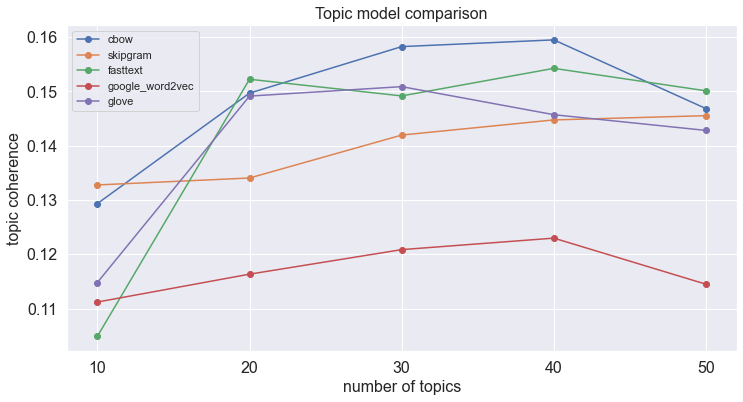

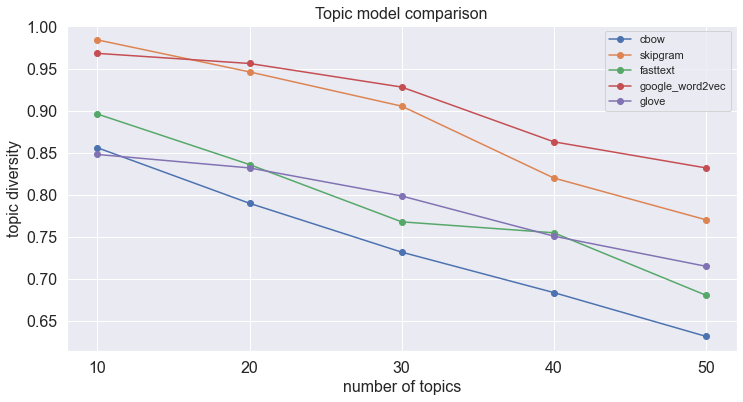

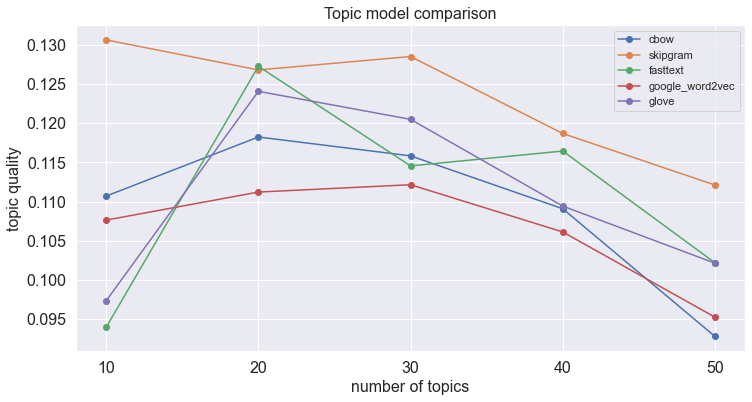

In [69]:
from src.model_comparison import load_metrics, display_metric

topics_list = [10, 20, 30, 40, 50]
embedding_list = {'cbow': 300, 'skipgram': 300, 'fasttext': 300, 'google_word2vec': 300, 'glove': 300}#, 'random': 300}

etm_tc, etm_td, etm_tq = load_metrics(topics_list, embedding_list, data_path, save_path)
    
display_metric(etm_tc, 'topic coherence')
display_metric(etm_td, 'topic diversity')
display_metric(etm_tq, 'topic quality')

### 6.ii. Qualitative analysis

<font color='blue'>INTERPRETATION OF TOPICS AND DOCUMENT REPRESENTATION</font>

In [77]:
from sklearn.manifold import TSNE
from ipywidgets import interact, fixed
#from src.qualitative_analysis import tsne_visualize_topics, tsne_visualize_words

In [80]:
model_file = 'ETM_' + data_path.split("/")[-1] + '_skipgram_10_parameters.pt'
best_model = torch.load(save_path + '/' + model_file)

theta = best_model['theta']
alpha = best_model['alpha']
rho = best_model['rho']
beta = best_model['beta']
vocab = best_model['vocab']
num_topics = alpha.shape[0]

In [91]:
# TOPIC DISTRIBUTION BY DOCUMENT
def get_doc_representation(theta, doc):
    data = {'topic': list(range(theta.shape[1])), 'distrib': list(theta[doc,])}
    df = pd.DataFrame(data)
    fig, ax = plt.subplots(figsize = (10,6))
    sns.barplot(x='topic', y='distrib', data=df, color='steelblue')
    plt.title('Topic distribution of document '+ str(doc), fontsize=18)
    plt.xlabel('topic', fontsize=18)
    plt.ylabel('weight', fontsize=18)
    plt.show()

interact(get_doc_representation, theta=fixed(theta), doc=widgets.IntSlider(min=0,max=theta.shape[0]-1,step=1,value=0))

interactive(children=(IntSlider(value=0, description='doc', max=6844), Output()), _dom_classes=('widget-intera…

<function __main__.get_doc_representation(theta, doc)>

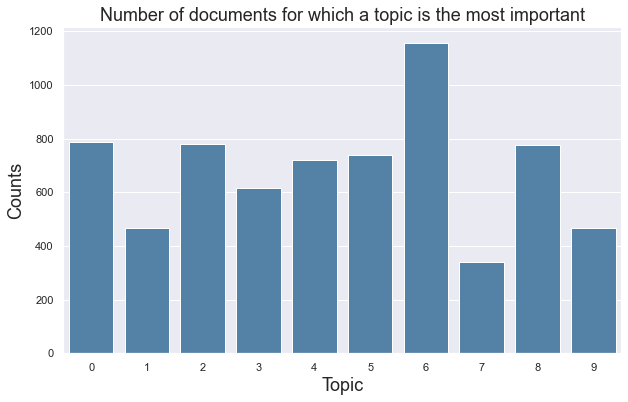

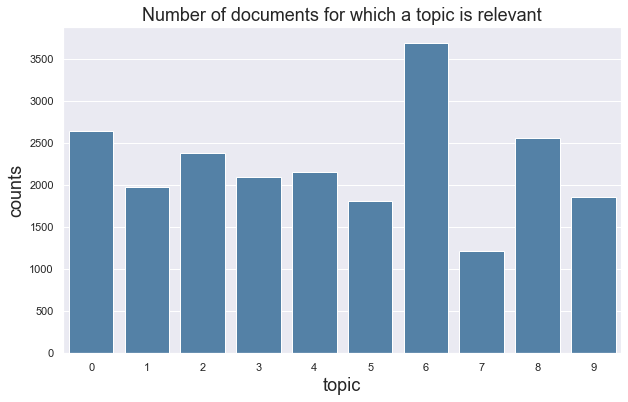

In [86]:
# BARPLOT NUM. DOCUMENTS IN WHICH A TOPIC IS THE MOST IMPORTANT
top_topics=list(np.argsort(-1 * theta, axis=1)[:,1])
count_top_topics = list()
for i in range(theta.shape[1]):
    count_top_topics.append((np.array(top_topics)==i).sum(axis=0))
data = {'topic': list(range(theta.shape[1])), 'counts': count_top_topics}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x='topic', y='counts', data=df, color='steelblue')
plt.title('Number of documents for which a topic is the most important', fontsize=18)
plt.xlabel('Topic', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.show()

# BARPLOT NUM. DOCUMENTS IN WHICH A TOPIC IS DETECTED (Θ above a threshold)
theta_threshold=1/theta.shape[1]
topic_ndocs=(theta>theta_threshold).sum(axis=0)
data = {'topic': list(range(theta.shape[1])), 'ndocs': list(topic_ndocs)}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x='topic', y='ndocs', data=df, color='steelblue')
plt.title("Number of documents for which a topic is relevant", fontsize=18)
plt.xlabel('topic', fontsize=18)
plt.ylabel('counts', fontsize=18)
plt.show()

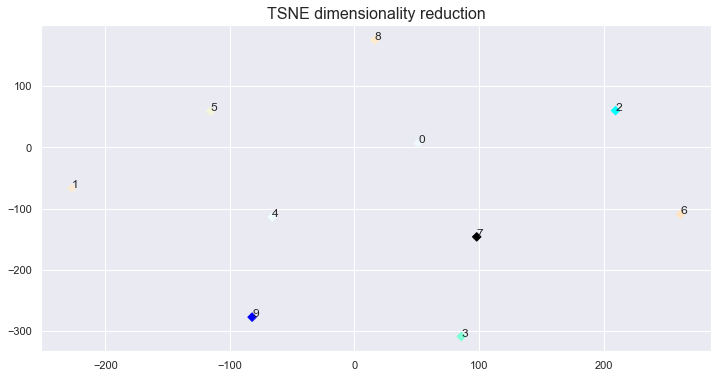

In [75]:
def tsne_visualize_topics(alpha):
    topics=alpha.shape[0]
    tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
    tsne_alpha = tsne_model.fit_transform(alpha)
    indexes = list(range(topics))
    
    colours=list(range(topics))    
    colormap = []
    for name, hex in matplotlib.colors.cnames.items():
        colormap.append(hex)
    colormap = colormap[:tsne_alpha.shape[0]]
    colormap = list(np.array(colormap))
    colours2 = [colormap[c] for c in colours]
    
    fig, ax = plt.subplots(figsize=(10,6))
   # plt.figure(figsize = (10,6))
    plt.rcParams['font.size'] = '12'
    sns.set(style = 'darkgrid')
    ax.scatter(x=tsne_alpha[:, 0], y=tsne_alpha[:, 1], c=colours2[:], marker='D', label='Topics')
    for i in list(range(topics)):
        ax.annotate(i, (tsne_alpha[i,0],tsne_alpha[i,1]))
    plt.title('TSNE dimensionality reduction', fontsize = 16)
    plt.show()
    
tsne_visualize_topics(alpha)

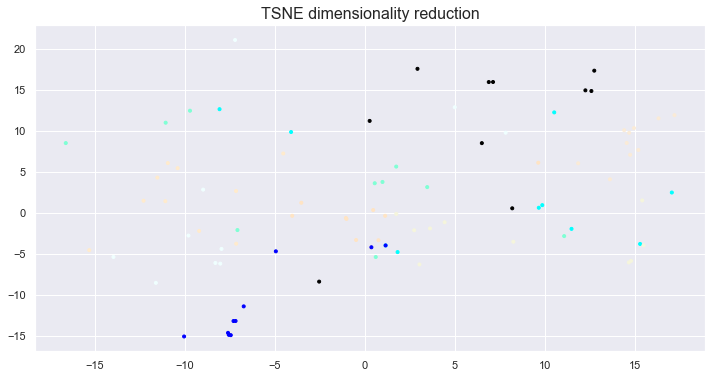

In [74]:
def tsne_visualize_words(rho, beta, topwords=10, topics=num_topics):
    tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(rho)
    topK=np.argsort(-1 * beta, axis=1)[:,0:topwords]
    topKvect=np.concatenate(topK)
    indexes = list(topKvect)
    tsne_lda_topK=tsne_lda[indexes,]
    
    colours=list()
    for i in range(topics):
        for j in range(topwords):
            colours.append(i)
    colormap = []
    for name, hex in matplotlib.colors.cnames.items():
        colormap.append(hex)
    colormap = colormap[:tsne_lda_topK.shape[0]]
    colormap = list(np.array(colormap))
    colours2 = [colormap[c] for c in colours]
    
    #fig, ax = plt.subplots(figsize=(10,6))
    plt.figure(figsize = (10,6))
    plt.rcParams['font.size'] = '12'
    sns.set(style = 'darkgrid')
    plt.scatter(x=tsne_lda_topK[topics:, 0], y=tsne_lda_topK[topics:, 1], c=colours2[topics:], marker='.', label='Words')
    for i in list(range(topics)):
        ax.annotate(i, (tsne_lda_topK[i,0],tsne_lda_topK[i,1]))
    plt.title('TSNE dimensionality reduction', fontsize = 16)
    plt.show()
    
tsne_visualize_words(rho, beta, topwords=10, topics=num_topics)

In [82]:
def barplot_topwords(topic, beta, vocab, topwords=10):
    topK=np.argsort(-1 * beta[topic,])[0:topwords]
    data = {'word': [str(vocab[i]) for i in list(topK)], 'beta': list(beta[topic,topK])}
    df = pd.DataFrame(data)
    
    fig, ax = plt.subplots(figsize = (10,6))
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)
        
    sns.barplot(x='beta', y='word', data=df, orient='h', edgecolor='black', color='steelblue')
    plt.title('Top ' + str(topwords) + ' words for topic ' + str(topic), fontsize = 18)
    plt.xlabel('Beta', fontsize=18)
    plt.ylabel('Word', fontsize=18)
    plt.show

interact(barplot_topwords,
         topic=list((range(alpha.shape[0]))),
         beta=fixed(beta),
         vocab=fixed(vocab),
         topwords=list((10,15,20)))

interactive(children=(Dropdown(description='topic', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Dropdown…

<function __main__.barplot_topwords(topic, beta, vocab, topwords=10)>

## 7. Dynamic Embedded Topic Model (DETM)

<font color='red'>BRIEF DESCRIPTION OF THE MODEL</font><br>
<font color='blue'>MODEL ESTIMATION</font><br>

**Memory problems:** DETM rquires too much memory!

In [ ]:
from src.main_DETM import main_DETM
main_DETM(dataset='un-general-debates', data_path='data/un-general-debates', save_path='data',
          emb_path='data/un-general-debates_embeddings.txt', mode='train', batch_size=1000,
          num_topics=50, train_embeddings=0, epochs=200, visualize_every=1000, tc=True)

## 8. Conclusion

<font color='red'>FINAL REMARKS</font>

### 8.i. Future work

We could consider a wider variety of word embeddings both fitted on the corpus or pre-trained on much wider corpuses. Here, we did not tune the parameters of *Word2vec* and *FastText*, however we could have optimized various parameters, such as the vector size, the window size, the number of *noise words* of the *negative sampling*, and so on.
As for the pre-trained word embeddings, we could consider the ones made available by *FastText* (see [here](https://fasttext.cc/docs/en/english-vectors.html)) or other versions of *GloVe* (see [here](https://nlp.stanford.edu/projects/glove/)); alternatively, we could consider the approach proposed in Gupta & Jaggi (2021) in which dymanic word embeddings are converted into static ones.

## References

Dieng, A. B., Ruiz, F. J., & Blei, D. M. (2019). The dynamic embedded topic model. arXiv preprint arXiv:[1907.05545](https://arxiv.org/abs/1907.05545).

Dieng, A. B., Ruiz, F. J., & Blei, D. M. (2020). Topic modeling in embedding spaces. Transactions of the Association for Computational Linguistics, 8, 439-453. [ACM Anthology](https://aclanthology.org/2020.tacl-1.29/),  [Arxiv link](https://arxiv.org/abs/1907.04907)

Gupta, P., & Jaggi, M. (2021). Obtaining better static word embeddings using contextual embedding models. arXiv preprint arXiv:[2106.04302](https://arxiv.org/abs/2106.04302).